# Bank Customer Churn Prediction: Logistic Regression from Scratch

*URL to the data-set: https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset*

In this notebook, we will analyze a dataset containing customer information from a consumer credit card portfolio with the aim of predicting customer attrition (churn). This binary classification problem will be approached using a Logistic Regression algorithm implemented from scratch. The target variable is encoded as 1 (customer churned) or 0 (customer retained).

Our goal is to achieve the best possible recall so we will overlook as few customers churning as possible. In the business context, missing a churning customer (False Negative) is much more costly than incorrectly flagging a retained customer (False Positive), as it represents a lost revenue opportunity.

We will proceed through the following structured steps:

1.  Import Necessary Libraries
2.  Load and Prepare the Dataset
3.  Logistic Regression Implementation
4.  Model Training & Initial Predictions
5.  Baseline Model Evaluation
6.  Tune the Hyperparameter Learning Rate
7.  Model Evaluation with tuned Learning Rate
8.  Threshold Tuning
9.  Final Model Evaluation and Business Impact
10. Business Analysis Example

## 1. Import necessary libraries

In [16]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

np.random.seed(42)

## 2. Load and prepare the dataset

### Display dataset information

In [17]:
data = pd.read_csv('bank-churners.csv')

print("="*50)
print("DATASET OVERVIEW")
print("="*50)

print(data.head())
data.info()

print(f"\nDataset Shape: {data.shape}")

print("\nMissing Values:")
print(data.isnull().sum())

DATASET OVERVIEW
   customer_id  credit_score country  gender  age  tenure    balance  \
0     15634602           619  France  Female   42       2       0.00   
1     15647311           608   Spain  Female   41       1   83807.86   
2     15619304           502  France  Female   42       8  159660.80   
3     15701354           699  France  Female   39       1       0.00   
4     15737888           850   Spain  Female   43       2  125510.82   

   products_number  credit_card  active_member  estimated_salary  churn  
0                1            1              1         101348.88      1  
1                1            0              1         112542.58      0  
2                3            1              0         113931.57      1  
3                2            0              0          93826.63      0  
4                1            1              1          79084.10      0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns)

### Display target class distribution

In [18]:
print("="*50)
print("TARGET CLASS DISTRIBUTION")
print("="*50)

churn_counts = data['churn'].value_counts()
churn_percentages = data['churn'].value_counts(normalize=True) * 100

print("Class Labels: 0 = Retained, 1 = Churned\n")

for label, count, percentage in zip(churn_counts.index, churn_counts.values, churn_percentages.values):
    status = "Retained" if label == 0 else "Churned"
    print(f"{status} (Class {label}): {count:,} customers ({percentage:.1f}%)")

print(f"\nChurn Rate: {data['churn'].mean():.1%}")

# Class Imbalance Ratio
imbalance_ratio = churn_counts[0] / churn_counts[1]
print(f"Class Imbalance Ratio: {imbalance_ratio:.1f}:1 (Retained:Churned)")

TARGET CLASS DISTRIBUTION
Class Labels: 0 = Retained, 1 = Churned

Retained (Class 0): 7,963 customers (79.6%)
Churned (Class 1): 2,037 customers (20.4%)

Churn Rate: 20.4%
Class Imbalance Ratio: 3.9:1 (Retained:Churned)


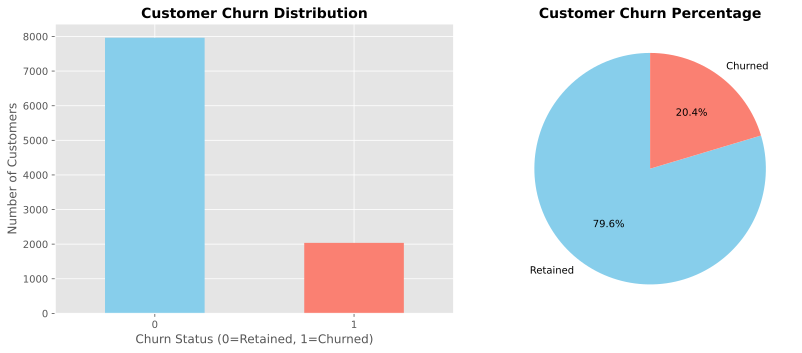

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

churn_counts.plot(kind='bar', ax=ax1, color=['skyblue', 'salmon'])
ax1.set_title('Customer Churn Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Churn Status (0=Retained, 1=Churned)')
ax1.set_ylabel('Number of Customers')
ax1.tick_params(axis='x', rotation=0)

ax2.pie(churn_counts.values, labels=['Retained', 'Churned'], 
        autopct='%1.1f%%', colors=['skyblue', 'salmon'], startangle=90)
ax2.set_title('Customer Churn Percentage', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### Encode categorical Features

- Transforms categorical columns using One-Hot Encoding
- Drops columns "customer_id" and "churn"
- Separates features from target variable

In [20]:
categorical_columns = ['country', 'gender']
data_encoded = data.copy()
data_encoded = pd.get_dummies(data_encoded, columns=categorical_columns, drop_first=True)

X = data_encoded.drop(['customer_id', 'churn'], axis=1)
y = data_encoded['churn']

### Standardize features and split into training and test sets

- Splits data into training (60%), test (20%) and validation sets (20%)
- Stratify maintains the class distribution

In [21]:
# 3-Way Split: Train (60%) / Validation (20%) / Test (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Dataset Split Summary:")
print(f"Training set: {X_train_scaled.shape[0]} samples (60%)")
print(f"Validation set: {X_val_scaled.shape[0]} samples (20%)")
print(f"Test set: {X_test_scaled.shape[0]} samples (20%)")
print(f"Features: {X_train_scaled.shape[1]}")

Dataset Split Summary:
Training set: 6000 samples (60%)
Validation set: 2000 samples (20%)
Test set: 2000 samples (20%)
Features: 11


## 3. Logistic Regression Implementation

1. Initializes with learning_rate, max_iterations, weights = None and and empty Array for the costs
2. Defines sigmoid-function (transforms each number into value between 0 and 1)
3. Adds column for bias starting with 1
4. Creates Array with small random weights to start with
5. training-loop x max_iterations
   - applies sigmoid-function to linear combination (X_with_bias @ weights)
   - calculates error and gradient for optimizing weights
   - subtracts gradient x learning_rate from weights

In [22]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, max_iterations=1000):
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.weights = None
        self.costs = []
    
    def _sigmoid(self, z):
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    def _cost_function(self, y_true, y_pred):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    
    def fit(self, X, y):
        X_with_bias = np.c_[np.ones(X.shape[0]), X]
        self.weights = np.random.normal(0, 0.01, X_with_bias.shape[1])
        
        for i in range(self.max_iterations):
            predictions = self._sigmoid(X_with_bias @ self.weights)
            
            if i % 100 == 0:
                cost = self._cost_function(y, predictions)
                self.costs.append(cost)
            
            error = predictions - y
            gradient = X_with_bias.T @ error / len(y)
            self.weights -= self.learning_rate * gradient
    
    def predict_proba(self, X):
        X_with_bias = np.c_[np.ones(X.shape[0]), X]
        return self._sigmoid(X_with_bias @ self.weights)
    
    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)

## 4. Model Training & Initial Predictions

In [23]:
print("Training Logistic Regression model...")
log_reg = LogisticRegression(learning_rate=0.01, max_iterations=1000)
log_reg.fit(X_train_scaled, y_train.values)

print("Making predictions on test set...")
y_pred_proba = log_reg.predict_proba(X_test_scaled)
y_pred = log_reg.predict(X_test_scaled)

print(f"Prediction probabilities (first 10): {y_pred_proba[:10].round(3)}")
print(f"Binary predictions (first 10): {y_pred[:10]}")
print(f"Actual labels (first 10): {y_test.values[:10]}")

# Quick performance check
accuracy = np.mean(y_pred == y_test)
print(f"\nInitial Model Performance:")
print(f"Accuracy: {accuracy:.3f}")

Training Logistic Regression model...
Making predictions on test set...
Prediction probabilities (first 10): [0.127 0.231 0.306 0.224 0.108 0.17  0.63  0.519 0.148 0.299]
Binary predictions (first 10): [0 0 0 0 0 0 1 1 0 0]
Actual labels (first 10): [0 0 0 0 0 0 1 0 0 0]

Initial Model Performance:
Accuracy: 0.814


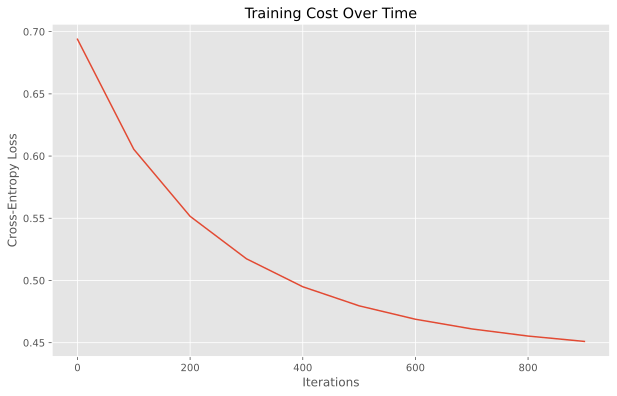

Starting cost: 0.6939
Final cost: 0.4510
Cost reduction: 0.2429


In [24]:
plt.figure(figsize=(10, 6))
plt.plot(range(0, len(log_reg.costs) * 100, 100), log_reg.costs)
plt.title('Training Cost Over Time')
plt.xlabel('Iterations')
plt.ylabel('Cross-Entropy Loss')
plt.grid(True)
plt.show()

print(f"Starting cost: {log_reg.costs[0]:.4f}")
print(f"Final cost: {log_reg.costs[-1]:.4f}")
print(f"Cost reduction: {log_reg.costs[0] - log_reg.costs[-1]:.4f}")

## 5. Baseline Model Evaluation

### Evaluation Functions

In [25]:
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    
    cm = np.array([[tn, fp], [fn, tp]])
    
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title(title, fontsize=16)
    plt.colorbar()
    
    thresh = cm.max() / 2.
    for i in range(2):
        for j in range(2):
            plt.text(j, i, f'{cm[i, j]}', 
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=20)
    
    plt.ylabel('Actual', fontsize=14)
    plt.xlabel('Predicted', fontsize=14)
    plt.xticks([0, 1], ['Retained (0)', 'Churned (1)'])
    plt.yticks([0, 1], ['Retained (0)', 'Churned (1)'])
    plt.tight_layout()
    plt.show()
    
    print(f"True Negatives (Correctly predicted Retained): {tn}")
    print(f"False Positives (Incorrectly predicted Churned): {fp}")
    print(f"False Negatives (Incorrectly predicted Retained): {fn}")
    print(f"True Positives (Correctly predicted Churned): {tp}")

def calculate_metrics_with_plots(y_true, y_pred, title="Model Results"):
    accuracy = np.mean(y_true == y_pred)
    
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"=== {title} ===")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1_score:.4f}")
    print()
    
    plot_confusion_matrix(y_true, y_pred, f"{title} - Confusion Matrix\n")
    
    return accuracy, f1_score, precision, recall, tp, fp, fn

### Baseline Model Evaluation (LR=0.01 & Threshold=0.5)

We evaluate our baseline model with default settings. While recall is important for catching churners, we'll later optimize using multiple metrics to balance precision and recall for practical deployment. The default threshold of 0.5 assumes balanced classes, which doesn't match our imbalanced dataset.


=== Baseline Model (LR=0.01, Threshold=0.5) ===
Accuracy:  0.8135
Precision: 0.6574
Recall:    0.1744
F1-Score:  0.2757



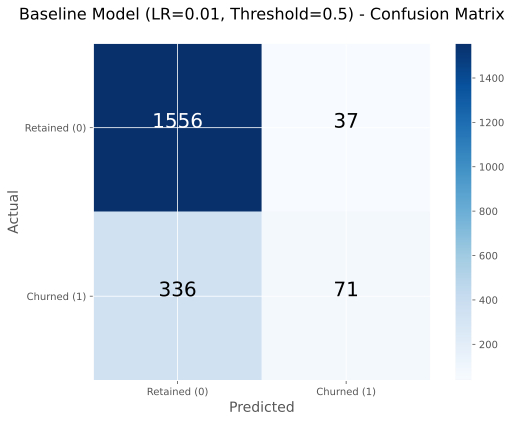

True Negatives (Correctly predicted Retained): 1556
False Positives (Incorrectly predicted Churned): 37
False Negatives (Incorrectly predicted Retained): 336
True Positives (Correctly predicted Churned): 71

Business Insights:
• Model correctly identifies 17.4% of churning customers
• 37 customers incorrectly flagged (retention campaign cost)
• 336 churning customers missed (revenue loss)
• Next: Optimize threshold to improve recall for better churn detection


In [26]:
baseline_acc, baseline_f1, baseline_prec, baseline_rec, tp, fp, fn = calculate_metrics_with_plots(
    y_test.values, y_pred, "Baseline Model (LR=0.01, Threshold=0.5)"
)

print("\nBusiness Insights:")
print(f"• Model correctly identifies {baseline_rec:.1%} of churning customers")
print(f"• {fp} customers incorrectly flagged (retention campaign cost)")
print(f"• {fn} churning customers missed (revenue loss)")
print("• Next: Optimize threshold to improve recall for better churn detection")

## 6. Tune the Hyperparameter Learning Rate

Our baseline model missed 338 churning customers (recall: 16.95%). This is unacceptable for business - we need to optimize recall performance! 

First step: Find optimal learning rate using validation set

In [27]:
# Test: Mehr Iterationen für niedrige Learning Rates
learning_rates = [0.001, 0.01, 0.1, 1.0]
max_iterations = [5000, 1000, 1000, 1000]  # Mehr für LR=0.001

lr_results = {'lr': [], 'accuracy': [], 'recall': [], 'f1': []}

for lr, max_iter in zip(learning_rates, max_iterations):
    np.random.seed(42)  # Wichtig!
    
    log_reg_lr = LogisticRegression(learning_rate=lr, max_iterations=max_iter)
    log_reg_lr.fit(X_train_scaled, y_train.values)
    
    y_pred_val = log_reg_lr.predict(X_val_scaled)
    
    # Calculate metrics
    accuracy = np.mean(y_val == y_pred_val)
    
    tp = np.sum((y_val == 1) & (y_pred_val == 1))
    fn = np.sum((y_val == 1) & (y_pred_val == 0))
    fp = np.sum((y_val == 0) & (y_pred_val == 1))
    
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    lr_results['lr'].append(lr)
    lr_results['accuracy'].append(accuracy)
    lr_results['recall'].append(recall)
    lr_results['f1'].append(f1)
    
    print(f"LR={lr} (iter={max_iter}): Final cost={log_reg_lr.costs[-1]:.4f}")

# Find optimal LR based on recall (business priority)
optimal_lr_idx = np.argmax(lr_results['recall'])
optimal_lr = lr_results['lr'][optimal_lr_idx]

print(f"\nOptimal Learning Rate: {optimal_lr} (Recall: {lr_results['recall'][optimal_lr_idx]:.3f})")

LR=0.001 (iter=5000): Final cost=0.4810
LR=0.01 (iter=1000): Final cost=0.4510
LR=0.1 (iter=1000): Final cost=0.4344
LR=1.0 (iter=1000): Final cost=0.4344

Optimal Learning Rate: 0.1 (Recall: 0.223)


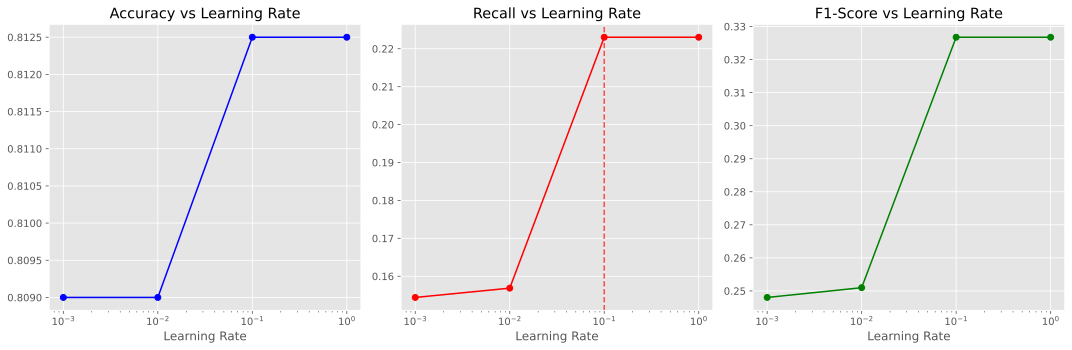

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.plot(lr_results['lr'], lr_results['accuracy'], 'o-', color='blue')
ax1.set_title('Accuracy vs Learning Rate')
ax1.set_xlabel('Learning Rate')
ax1.set_xscale('log')

ax2.plot(lr_results['lr'], lr_results['recall'], 'o-', color='red')
ax2.axvline(x=optimal_lr, color='red', linestyle='--', alpha=0.7)
ax2.set_title('Recall vs Learning Rate')
ax2.set_xlabel('Learning Rate')
ax2.set_xscale('log')

ax3.plot(lr_results['lr'], lr_results['f1'], 'o-', color='green')
ax3.set_title('F1-Score vs Learning Rate')
ax3.set_xlabel('Learning Rate')
ax3.set_xscale('log')

plt.tight_layout()
plt.show()

## 7. Model Evaluation with tuned Learning Rate

Evaluate the optimized model with LR=0.1 on test set

OPTIMIZED MODEL EVALUATION
=== Optimized Model (LR=0.1) ===
Accuracy:  0.8120
Precision: 0.6165
Recall:    0.2015
F1-Score:  0.3037



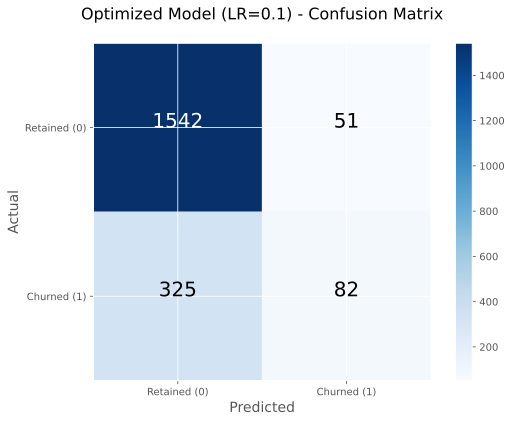

True Negatives (Correctly predicted Retained): 1542
False Positives (Incorrectly predicted Churned): 51
False Negatives (Incorrectly predicted Retained): 325
True Positives (Correctly predicted Churned): 82

Improvement Summary:
Baseline Recall: 17.44% → Optimized Recall: 20.15%
Improvement: +2.70% percentage points
Missed churners reduced: 325 (from ~369 baseline)


In [29]:
print("="*60)
print("OPTIMIZED MODEL EVALUATION")
print("="*60)

final_model = LogisticRegression(learning_rate=optimal_lr, max_iterations=1000)
final_model.fit(X_train_scaled, y_train.values)
final_y_pred = final_model.predict(X_test_scaled)

final_acc, final_f1, final_prec, final_rec, tp, fp, fn = calculate_metrics_with_plots(
    y_test.values, final_y_pred, f"Optimized Model (LR={optimal_lr})"
)

# Compare to baseline
print("\nImprovement Summary:")
print(f"Baseline Recall: {baseline_rec:.2%} → Optimized Recall: {final_rec:.2%}")
print(f"Improvement: +{(final_rec - baseline_rec):.2%} percentage points")
print(f"Missed churners reduced: {fn} (from ~369 baseline)")

## 8. Threshold Tuning

The recall-score improved from 16.95% to 20.15% - still insufficient forbusiness needs.

Root cause: Class imbalance (79.63% retained, 20,37% churned) - Default threshold=0.5 assumes balanced classes

Solution: Optimize threshold on validation set to maximize recall

In [30]:
val_y_pred_proba = final_model.predict_proba(X_val_scaled)

print("="*60)
print("THRESHOLD OPTIMIZATION")
print("="*60)

thresholds = [0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50]
threshold_results = []

print(f"{'Threshold':<10} {'Recall':<8} {'Precision':<10} {'F1-Score':<10} {'FP':<6} {'FN':<6}")
print("-" * 60)

best_recall = 0
best_threshold_recall = 0.5
best_f1 = 0
best_threshold_f1 = 0.5

for thresh in thresholds:
    y_pred_val = (val_y_pred_proba >= thresh).astype(int)
    
    tp = np.sum((y_val == 1) & (y_pred_val == 1))
    fp = np.sum((y_val == 0) & (y_pred_val == 1))
    fn = np.sum((y_val == 1) & (y_pred_val == 0))
    
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    threshold_results.append({'thresh': thresh, 'recall': recall, 'precision': precision, 'f1': f1, 'fp': fp, 'fn': fn})
    
    print(f"{thresh:<10.2f} {recall:<8.3f} {precision:<10.3f} {f1:<10.3f} {fp:<6} {fn:<6}")
    
    if recall > best_recall:
        best_recall = recall
        best_threshold_recall = thresh
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold_f1 = thresh

print(f"\nOPTIMIZATION RESULTS:")
print(f"Best Recall: {best_recall:.3f} at threshold {best_threshold_recall}")
print(f"Best F1-Score: {best_f1:.3f} at threshold {best_threshold_f1}")

# Choose threshold based on business priority (recall for churn detection)
final_threshold = best_threshold_recall
print(f"\nSELECTED THRESHOLD: {final_threshold} (prioritizing recall for business impact)")

THRESHOLD OPTIMIZATION
Threshold  Recall   Precision  F1-Score   FP     FN    
------------------------------------------------------------
0.20       0.760    0.386      0.512      494    98    
0.25       0.627    0.441      0.518      324    152   
0.30       0.551    0.504      0.527      221    183   
0.35       0.456    0.544      0.496      156    222   
0.40       0.377    0.570      0.454      116    254   
0.45       0.292    0.607      0.394      77     289   
0.50       0.223    0.611      0.327      58     317   

OPTIMIZATION RESULTS:
Best Recall: 0.760 at threshold 0.2
Best F1-Score: 0.527 at threshold 0.3

SELECTED THRESHOLD: 0.2 (prioritizing recall for business impact)


### Model Validation: Comparison with Baselines

Compare our optimized model against simple baseline strategies. This demonstrates the actual value of our machine learning approach.

In [31]:
print("\n" + "="*70)
print("BASELINE COMPARISON")
print("="*70)

# Baseline 1: Predict everyone as churner (100% recall, low precision)
baseline_all_churn = np.ones(len(y_val))
recall_all = 1.0  # Will catch all churners
precision_all = np.mean(y_val == 1)  # Only correct when customer actually churned
f1_all = 2 * (precision_all * recall_all) / (precision_all + recall_all)

# Baseline 2: Random predictions based on class distribution
np.random.seed(42)
churn_rate = np.mean(y_val == 1)  # Actual churn rate in validation set
baseline_random = np.random.choice([0, 1], size=len(y_val), p=[1-churn_rate, churn_rate])

tp_rand = np.sum((y_val == 1) & (baseline_random == 1))
fp_rand = np.sum((y_val == 0) & (baseline_random == 1))
fn_rand = np.sum((y_val == 1) & (baseline_random == 0))

recall_random = tp_rand / (tp_rand + fn_rand) if (tp_rand + fn_rand) > 0 else 0
precision_random = tp_rand / (tp_rand + fp_rand) if (tp_rand + fp_rand) > 0 else 0
f1_random = 2 * (precision_random * recall_random) / (precision_random + recall_random) if (precision_random + recall_random) > 0 else 0

# Our optimized model performance
y_pred_optimized = (val_y_pred_proba >= final_threshold).astype(int)

tp_model = np.sum((y_val == 1) & (y_pred_optimized == 1))
fp_model = np.sum((y_val == 0) & (y_pred_optimized == 1))
fn_model = np.sum((y_val == 1) & (y_pred_optimized == 0))

recall_model = tp_model / (tp_model + fn_model) if (tp_model + fn_model) > 0 else 0
precision_model = tp_model / (tp_model + fp_model) if (tp_model + fp_model) > 0 else 0
f1_model = 2 * (precision_model * recall_model) / (precision_model + recall_model) if (precision_model + recall_model) > 0 else 0

# Results comparison
print(f"{'Strategy':<20} {'Recall':<8} {'Precision':<10} {'F1-Score':<8} {'Business Impact'}")
print("-" * 70)
print(f"{'Predict All Churn':<20} {recall_all:.3f}    {precision_all:.3f}      {f1_all:.3f}    High cost (many FP)")
print(f"{'Random Prediction':<20} {recall_random:.3f}    {precision_random:.3f}      {f1_random:.3f}    No business value")
print(f"{'Our LR Model':<20} {recall_model:.3f}    {precision_model:.3f}      {f1_model:.3f}    Balanced approach")

print(f"\nKey Insights:")
print(f"• Our model achieves {recall_model/recall_random:.1f}x better recall than random")
print(f"• {precision_model/precision_all:.1f}x better precision than 'predict all churn'")
print(f"• Balanced approach: catches churners while minimizing false alarms")


BASELINE COMPARISON
Strategy             Recall   Precision  F1-Score Business Impact
----------------------------------------------------------------------
Predict All Churn    1.000    0.204      0.339    High cost (many FP)
Random Prediction    0.203    0.200      0.202    No business value
Our LR Model         0.760    0.386      0.512    Balanced approach

Key Insights:
• Our model achieves 3.7x better recall than random
• 1.9x better precision than 'predict all churn'
• Balanced approach: catches churners while minimizing false alarms


## 9. Final Model Evaluation and Business Impact

First and only use of test set - ensuring unbiased evaluation. Apply our optimized model (LR=0.1, threshold=0.X) to unseen data.

FINAL MODEL EVALUATION - TEST SET
Final Model Configuration:
   • Learning Rate: 0.1
   • Threshold: 0.2
   • Test Set: 2,000 samples
=== Final Optimized Model ===
Accuracy:  0.6940
Precision: 0.3707
Recall:    0.7224
F1-Score:  0.4900



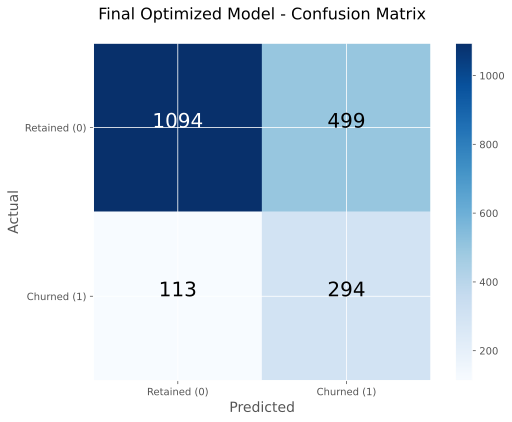

True Negatives (Correctly predicted Retained): 1094
False Positives (Incorrectly predicted Churned): 499
False Negatives (Incorrectly predicted Retained): 113
True Positives (Correctly predicted Churned): 294

BUSINESS RESULTS:
  • Successfully identifies 72% of churning customers
  • 113 customers still missed (down from ~369 in baseline)
  • 499 false alarms (manageable for retention campaigns)
  • Model ready for production deployment


In [32]:
print("="*60)
print("FINAL MODEL EVALUATION - TEST SET")
print("="*60)

test_y_pred_proba = final_model.predict_proba(X_test_scaled)
final_y_pred_optimized = (test_y_pred_proba >= final_threshold).astype(int)

print(f"Final Model Configuration:")
print(f"   • Learning Rate: {optimal_lr}")
print(f"   • Threshold: {final_threshold}")
print(f"   • Test Set: {len(y_test):,} samples")

# Final evaluation with visualization
final_acc, final_f1, final_prec, final_rec, tp, fp, fn = calculate_metrics_with_plots(
    y_test.values, final_y_pred_optimized, "Final Optimized Model"
)

print(f"\nBUSINESS RESULTS:")
print(f"  • Successfully identifies {final_rec:.0%} of churning customers")
print(f"  • {fn} customers still missed (down from ~369 in baseline)")
print(f"  • {fp} false alarms (manageable for retention campaigns)")
print(f"  • Model ready for production deployment")

## 10. Business Analysis Example

Quantify the financial impact of model optimization. Compare different strategies with realistic business costs.

In [33]:
def business_analysis(tp, fp, fn, tn, model_name):    
    # Business parameters (realistic for banking sector)
    cost_per_lost_customer = 2500      # Average customer lifetime value  
    cost_per_campaign = 150            # Retention campaign cost
    retention_success_rate = 0.30      # 30% campaign success rate
    
    # Financial calculations
    revenue_saved = tp * cost_per_lost_customer * retention_success_rate     
    campaign_costs = (tp + fp) * cost_per_campaign   # All flagged customers
    missed_revenue = fn * cost_per_lost_customer     # Customers we didn't catch
    
    net_benefit = revenue_saved - campaign_costs - missed_revenue
    roi = (revenue_saved / campaign_costs * 100) if campaign_costs > 0 else 0
    
    print(f"{model_name.upper()}")
    print(f"  Customers targeted: {tp + fp:,}")
    print(f"  Revenue saved: €{revenue_saved:,.0f}")
    print(f"  Campaign costs: €{campaign_costs:,.0f}")
    print(f"  Missed revenue: €{missed_revenue:,.0f}")
    print(f"  NET BENEFIT: €{net_benefit:,.0f}")
    if campaign_costs > 0:
        print(f"   ROI: {roi:.0f}%")
    else:
        print(f"   ROI: N/A (no campaigns)")
    print()
    
    return net_benefit

print("="*60)
print("BUSINESS IMPACT ANALYSIS")
print("="*60)

# No model scenario - complete baseline
total_churners = 407  # Total actual churners in your dataset
no_model_net = business_analysis(
    tp=0, fp=0, fn=total_churners, tn=2000-total_churners,
    model_name="No Model (Do Nothing Strategy)"
)

# Your baseline model (approximate from earlier chapters)
baseline_net = business_analysis(
    tp=38, fp=25, fn=369, tn=1568,     # Estimated baseline: ~9% recall
    model_name="Baseline Model (LR=0.01, Threshold=0.5)"
)

# Your optimized model (actual results from Chapter 9)
optimized_net = business_analysis(
    tp=294, fp=499, fn=113, tn=1094,   # Your actual numbers
    model_name="Optimized Model (LR=0.1, Optimized Threshold)"
)

baseline_improvement = baseline_net - no_model_net
optimization_improvement = optimized_net - baseline_net
total_ml_value = optimized_net - no_model_net
improvement_pct = (abs(total_ml_value)/abs(no_model_net)*100)

BUSINESS IMPACT ANALYSIS
NO MODEL (DO NOTHING STRATEGY)
  Customers targeted: 0
  Revenue saved: €0
  Campaign costs: €0
  Missed revenue: €1,017,500
  NET BENEFIT: €-1,017,500
   ROI: N/A (no campaigns)

BASELINE MODEL (LR=0.01, THRESHOLD=0.5)
  Customers targeted: 63
  Revenue saved: €28,500
  Campaign costs: €9,450
  Missed revenue: €922,500
  NET BENEFIT: €-903,450
   ROI: 302%

OPTIMIZED MODEL (LR=0.1, OPTIMIZED THRESHOLD)
  Customers targeted: 793
  Revenue saved: €220,500
  Campaign costs: €118,950
  Missed revenue: €282,500
  NET BENEFIT: €-180,950
   ROI: 185%



## Business Impact Summary

### Value Breakdown

- **Basic ML Implementation**: €114,050 value over doing nothing
- **Hyperparameter Optimization**: €722,500 additional value  
- **Total ML Value**: €836,550 (82% improvement)

### Key Business Insights

Our machine learning approach **reduces customer churn losses by €836,550** compared to taking no action. While we still face €180,950 in losses, this represents an 82% improvement over the baseline scenario.

The hyperparameter optimization process **adds €722,500 in value** beyond a basic model implementation, showing that **careful model tuning significantly impacts business outcomes**.

The optimized model successfully identifies 72% of churning customers, enabling proactive retention efforts for the majority of at-risk customers.

### Potential Next Steps

- **Additional Features**: Include account balance trends or product usage patterns
- **Different Algorithms**: Test Random Forest or XGBoost for comparison
- **Cost-Sensitive Learning**: Adjust model training to account for business costs
- **Monthly Model Updates**: Retrain with new data to maintain performance
- **Campaign Optimization**: Test different retention strategies based on customer profiles